# DynUNet Implementation for Wrist Bone Segmentation
In this section, we explore the DynUNet architecture for the segmentation of wrist bones. DynUNet is a dynamic adaptation of the classic UNet model, specifically designed to improve performance in medical image segmentation tasks. Known for its flexible configuration and efficient multi-scale feature extraction, DynUNet provides precise and consistent results. By employing the DynUNet model, we aim to harness its strengths in capturing complex anatomical structures and variations, thus ensuring accurate and detailed segmentation of wrist bones. This method highlights the model’s capability to maintain spatial hierarchies while adapting to various input dimensions, enhancing its ability to resolve intricate details within the segmentation process.

### Importing Necessary Libraries

In [1]:
import os
from glob import glob
from monai.transforms import (
    Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, RandFlipd,
    RandAffined, RandRotated, RandZoomd, NormalizeIntensityd, ToTensord, EnsureTyped, 
RandGaussianNoised,RandGaussianSmoothd,RandScaleIntensityd,RandShiftIntensityd,ScaleIntensityd
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism, first
from monai.networks.nets import DynUNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import AsDiscrete, Activations
import torch
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib import colors
from monai.metrics import SurfaceDistanceMetric

print("All libraries have been successfully Imported!!!")

All libraries have been successfully Imported!!!


### Data Loaders and Data Transformations

In [2]:
## CREATING PATHS TO UPLOAD OUR DATA
data_dir = '/workspace/data'

train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*nii.gz')))

val_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

In [3]:
orig_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

# Defining training transforms
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    RandAffined(keys=['image', 'label'], prob=0.5, rotate_range=(0, 0, np.pi/12), scale_range = (0.1,0.1,0.1),
                mode=("nearest", "nearest")), 
    EnsureTyped(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

# Defining validation transforms
val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

In [4]:
# Creating datasets and dataloaders
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
orig_ds = Dataset(data=train_files, transform=orig_transforms)

In [5]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size = 2)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size =2)

val_ds = Dataset(data=val_files, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size = 2)

test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [6]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(0.)
tensor(1.)


### Comparing Original Image with Preprocessed Image and Labels
In this section, we compare the original images with their preprocessed counterparts and corresponding labels. This comparison highlights the impact of preprocessing on image quality and segmentation accuracy. Preprocessing steps such as normalization, augmentation, and transformation enhance the model's ability to accurately segment the wrist bones by improving the contrast and highlighting relevant features. This analysis is crucial for understanding how preprocessing contributes to the overall performance of the segmentation model.

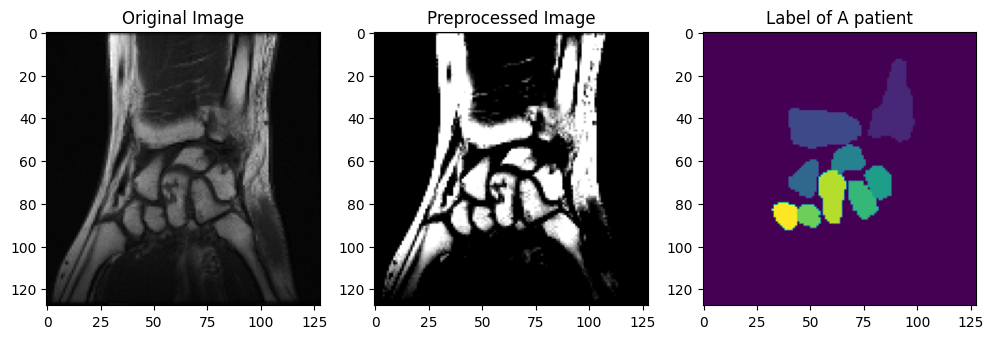

In [7]:
plt.figure('test',(12,6))


plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(orig_patient['image'][0,0,:,:,21], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,2)
plt.title('Preprocessed Image')
plt.imshow(test_patient['image'][0,0,:,:,21], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,3)
plt.title('Label of A patient')
plt.imshow(test_patient['label'][0,0,:,:,21])  

### Evaluation of the Model
In this section, we evaluate the ensemble model's performance by calculating the Dice metric and Average Symmetric Surface Distance (ASSD) for each of the 10 wrist bones. These metrics provide insights into the segmentation accuracy and spatial agreement between predicted and actual bone structures.

### 1. Dice Metrics Calculation

In [8]:
# Loading the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],  # Using 4 elements to match the number of strides
    strides=[1, 2, 2, 2],  # Adjusted strides to avoid negative padding
    upsample_kernel_size=[2, 2, 2],  # Changed to list
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)

dice_metric = DiceMetric(include_background=True, reduction="mean")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_metric_model_dyunet.pth"))
model.eval()

# Function to calculate the mean and std deviation of dice scores
def calculate_mean_std(dice_scores):
    mean_dice = torch.mean(dice_scores, dim=0)
    std_dice = torch.std(dice_scores, dim=0)
    return mean_dice, std_dice

# Evaluating and printing the dice coefficient for every label achieved through the best model
with torch.no_grad():
    dice_metric_batch = DiceMetric(include_background=True, reduction="none")
    all_dice_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating dice metric for each batch
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

        # Storing dice scores for the current batch
        batch_dice_scores = dice_metric_batch.aggregate()
        all_dice_scores.append(batch_dice_scores)

        # Resetting for the next batch
        dice_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_dice_scores = torch.cat(all_dice_scores, dim=0)

    # Calculating mean and standard deviation
    mean_dice, std_dice = calculate_mean_std(all_dice_scores)

    print("Final per-class Dice metrics:")
    for i, (mean, std) in enumerate(zip(mean_dice, std_dice)):
        print(f"Class {i} dice: {mean.item():.4f} +/- {std.item():.4f}")

Final per-class Dice metrics:
Class 0 dice: 0.9904 +/- 0.0015
Class 1 dice: 0.8473 +/- 0.0680
Class 2 dice: 0.9180 +/- 0.0171
Class 3 dice: 0.8850 +/- 0.0360
Class 4 dice: 0.9022 +/- 0.0298
Class 5 dice: 0.8582 +/- 0.0402
Class 6 dice: 0.9070 +/- 0.0299
Class 7 dice: 0.8685 +/- 0.0449
Class 8 dice: 0.9281 +/- 0.0154
Class 9 dice: 0.8143 +/- 0.0734
Class 10 dice: 0.8425 +/- 0.0777


### 2. Average Symmetric Surface Distance (ASSD)

In [9]:
# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_metric_model_dyunet.pth"))
model.eval()

# Function to calculate the mean and std deviation of metrics
def calculate_mean_std(metric_scores):
    mean_metric = torch.mean(metric_scores, dim=0)
    std_metric = torch.std(metric_scores, dim=0)
    return mean_metric, std_metric

# Evaluating and printing the ASSD for every label achieved through the best model
with torch.no_grad():
    surface_distance_metric_batch = SurfaceDistanceMetric(include_background=True, reduction="none")

    all_assd_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating ASSD for each batch
        surface_distance_metric_batch(y_pred=val_outputs, y=val_labels)
        batch_assd_scores = surface_distance_metric_batch.aggregate()
        all_assd_scores.append(batch_assd_scores)
        surface_distance_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_assd_scores = torch.cat(all_assd_scores, dim=0)

    # Calculating mean and standard deviation
    mean_assd, std_assd = calculate_mean_std(all_assd_scores)

    print("Final per-class ASSD metrics:")
    for i, (mean_a, std_a) in enumerate(zip(mean_assd, std_assd)):
        print(f"Class {i} ASSD: {mean_a.item():.4f} +/- {std_a.item():.4f}")

Final per-class ASSD metrics:
Class 0 ASSD: 0.1676 +/- 0.0119
Class 1 ASSD: 1.1004 +/- 0.4969
Class 2 ASSD: 0.7667 +/- 0.1411
Class 3 ASSD: 0.6307 +/- 0.1413
Class 4 ASSD: 0.5666 +/- 0.1250
Class 5 ASSD: 0.7188 +/- 0.1873
Class 6 ASSD: 0.6335 +/- 0.2029
Class 7 ASSD: 0.6346 +/- 0.1414
Class 8 ASSD: 0.5087 +/- 0.0891
Class 9 ASSD: 1.0494 +/- 0.3567
Class 10 ASSD: 0.7985 +/- 0.2906


### Data Visualization
In this section, we visualize the predicted segmentation masks of the wrist bones. We display all the bones together and also visualize each bone individually to better understand the segmentation output and evaluate the accuracy of each predicted structure.

/opt/conda/lib/python3.10/site-packages/monai/transforms/post/array.py:176: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


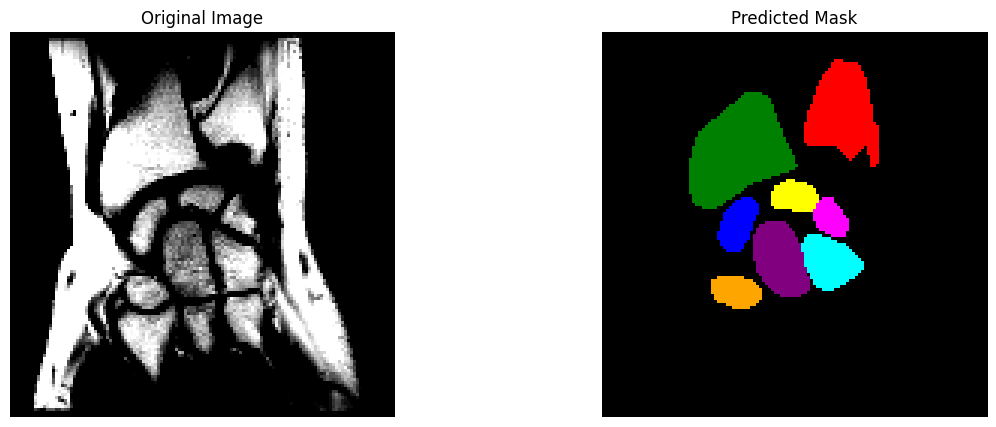

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


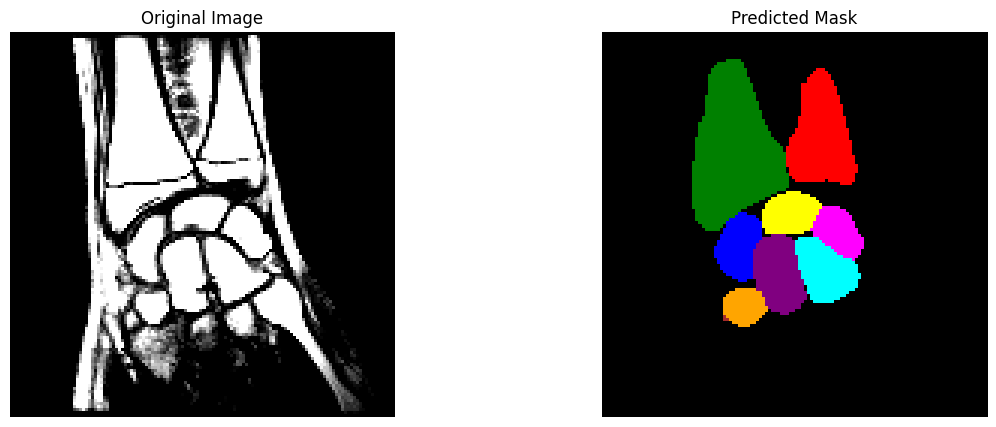

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


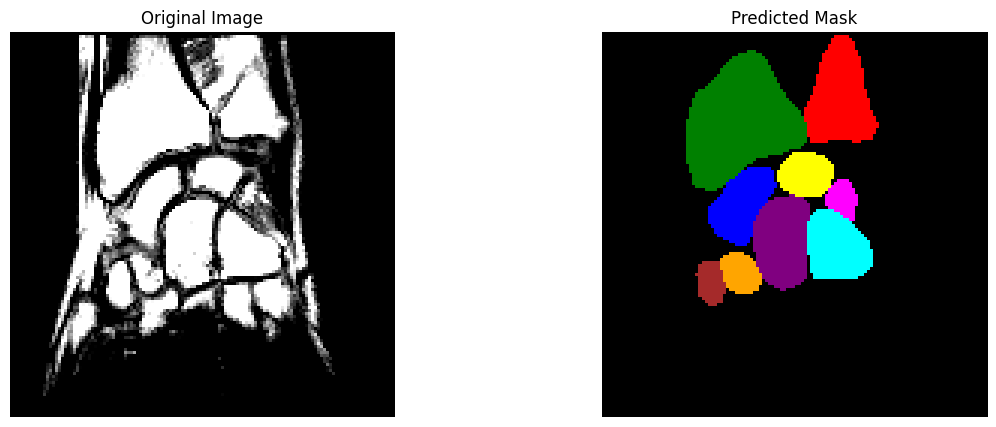

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


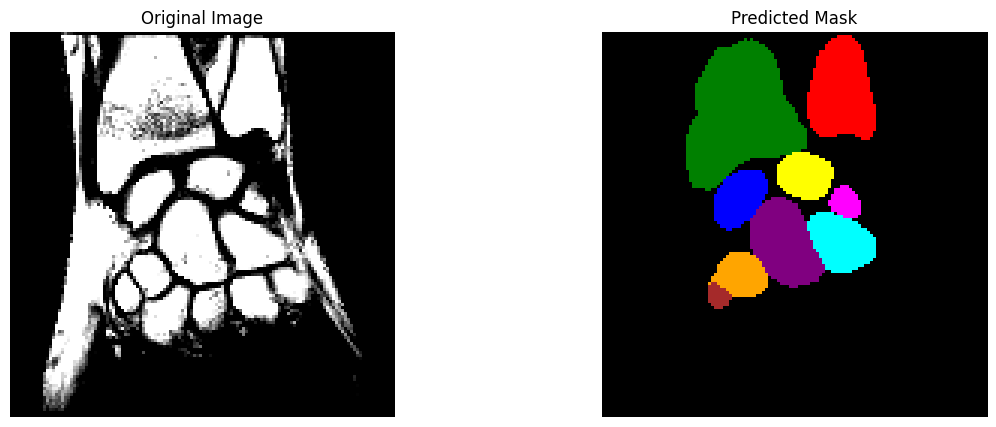

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


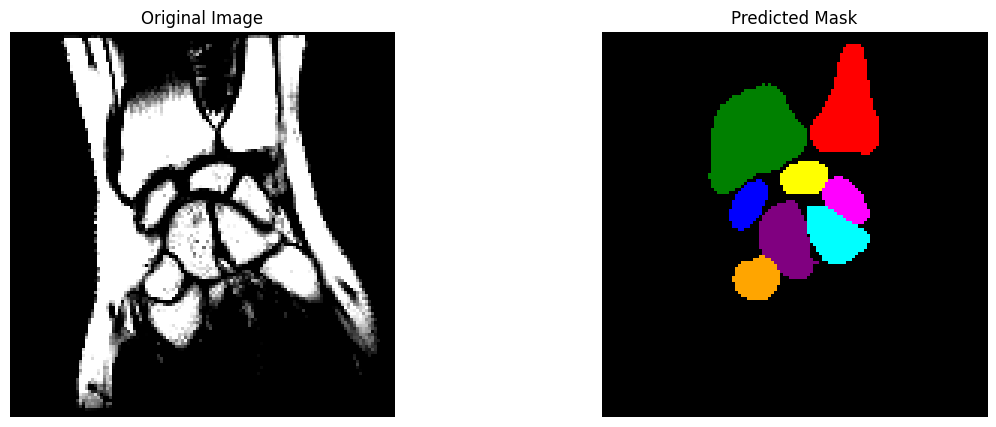

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


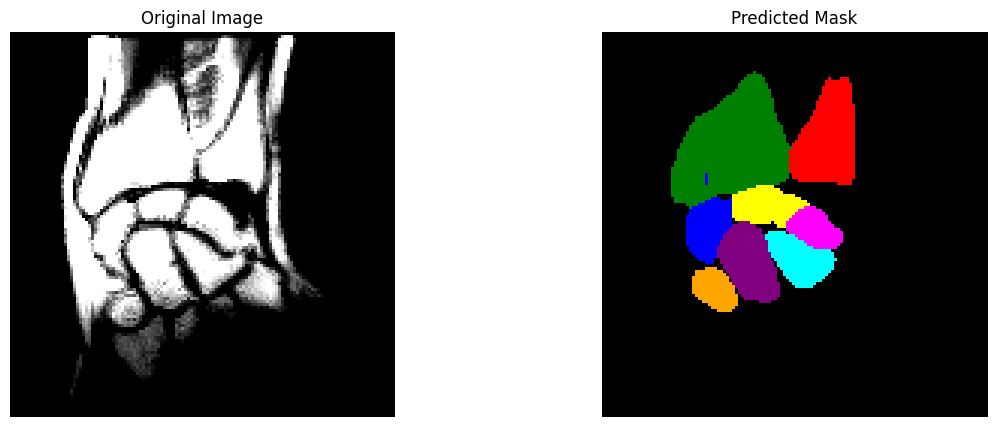

In [8]:
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  
os.makedirs(output_dir, exist_ok=True)

test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3], 
    strides=[1, 2, 2, 2],  
    upsample_kernel_size=[2, 2, 2],  
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)


model.load_state_dict(torch.load("best_metric_model_dyunet.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function with custom colormap
def visualize_results(image, prediction, slice_num, num_classes=11):
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  # Ensure correct shape selection
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results
    slice_num = 21 # Change this value to visualize different slices
    visualize_results(test_images.cpu().numpy(), predicted_mask, slice_num)

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


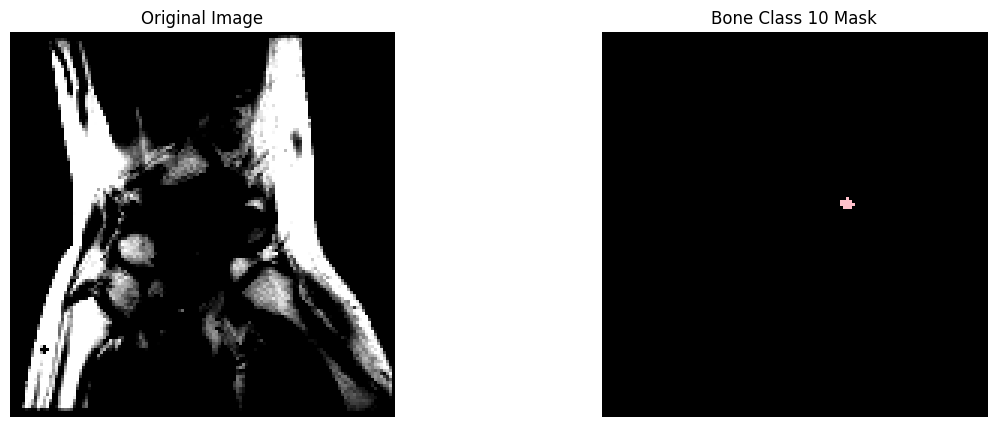

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


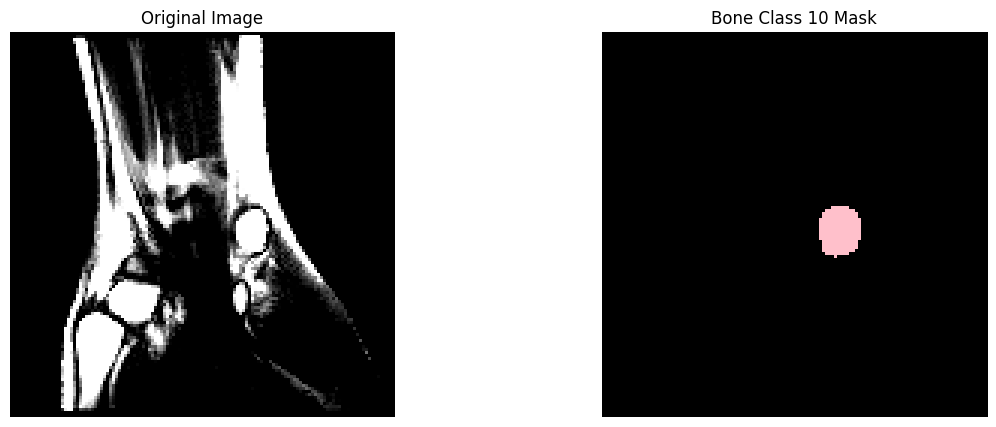

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


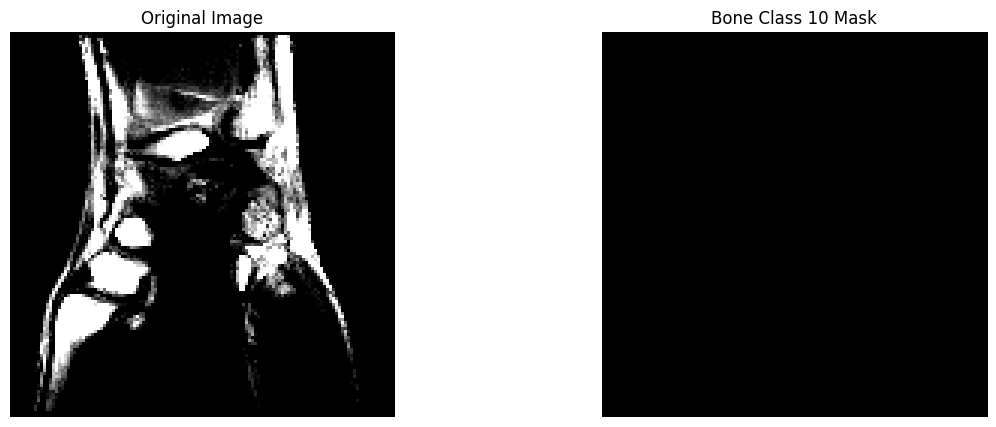

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


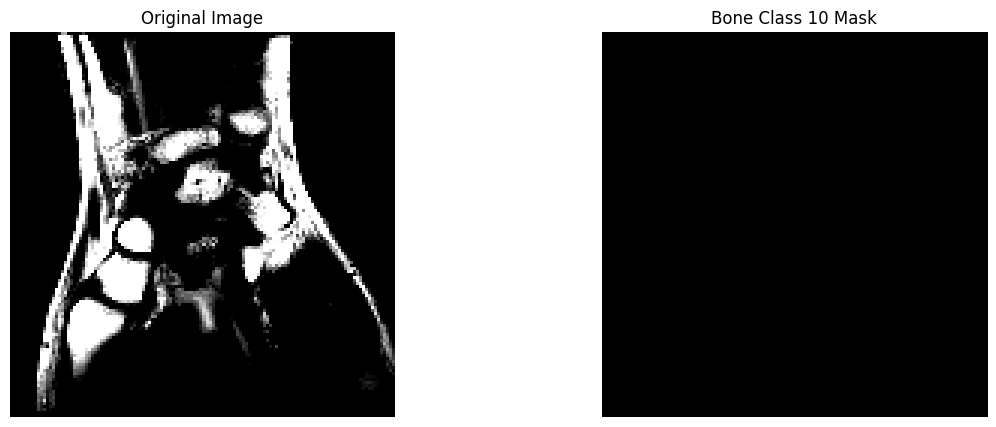

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


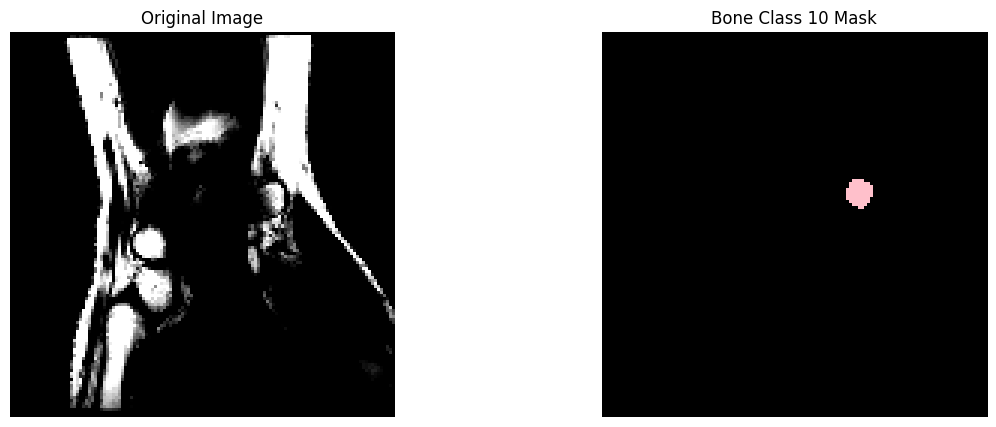

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


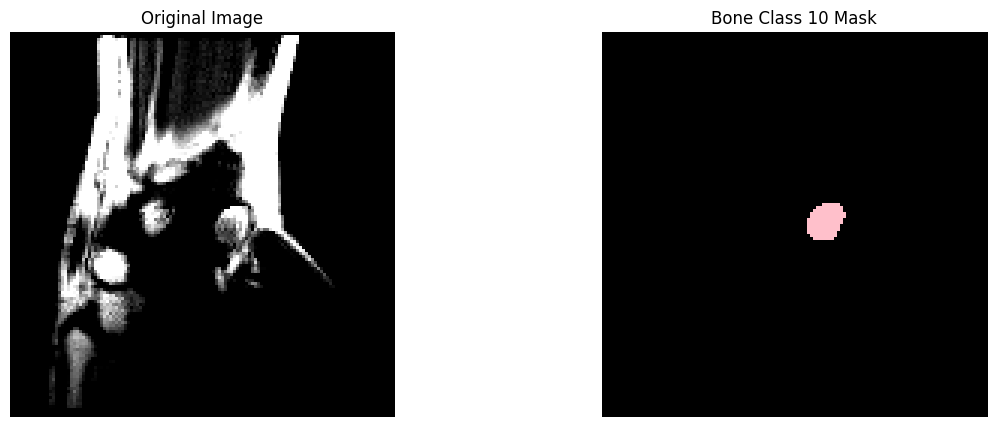

In [18]:
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  
os.makedirs(output_dir, exist_ok=True)


test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))


test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3], 
    strides=[1, 2, 2, 2],  
    upsample_kernel_size=[2, 2, 2],  
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)

model.load_state_dict(torch.load("best_metric_model_dyunet.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function for a specific bone class
def visualize_single_bone(image, prediction, bone_class, slice_num):
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Isolating the bone class from prediction
    bone_mask = (prediction == bone_class).astype(np.uint8) * bone_class  # Ensure correct class value

    plt.figure(figsize=(14, 5))

    # Displaying the original image slice
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # Displaying the predicted bone mask slice
    plt.subplot(1, 2, 2)
    plt.title(f"Bone Class {bone_class} Mask")
    plt.imshow(bone_mask[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
bone_class_to_visualize = 10
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results for the selected bone class
    slice_num = 35 
    visualize_single_bone(test_images.cpu().numpy(), predicted_mask, bone_class_to_visualize, slice_num)

### Saving Predicted Masks

In [12]:
# Directories
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks_dynunet'  # Output directory for predicted masks
os.makedirs(output_dir, exist_ok=True)

# File paths
test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=11,  # 10 bones + background
    kernel_size=[3, 3, 3, 3],  # Using 4 elements to match the number of strides
    strides=[1, 2, 2, 2],  # Adjusted strides to avoid negative padding
    upsample_kernel_size=[2, 2, 2],  # Changed to list
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)

model.load_state_dict(torch.load("best_metric_model_dyunet.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Function to save the predicted mask as a .nii.gz file
def save_predicted_mask_as_nii(prediction, affine, header, output_path):
    predicted_nifti = nib.Nifti1Image(prediction, affine, header)
    nib.save(predicted_nifti, output_path)

# Running inference and saving predicted masks
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    original_image_path = test_files[i]["image"]
    with torch.no_grad():
        # Get predictions from the model
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Saving the predicted mask as a .nii.gz file
    predicted_mask = test_outputs[0, 0, :, :, :]  # Extract the full 3D mask
    original_image = nib.load(original_image_path)  # Load the original image for affine and header
    output_filename = os.path.basename(original_image_path)  # Get the original filename
    output_path = os.path.join(output_dir, output_filename)  # Construct the output path
    save_predicted_mask_as_nii(predicted_mask, original_image.affine, original_image.header, output_path)

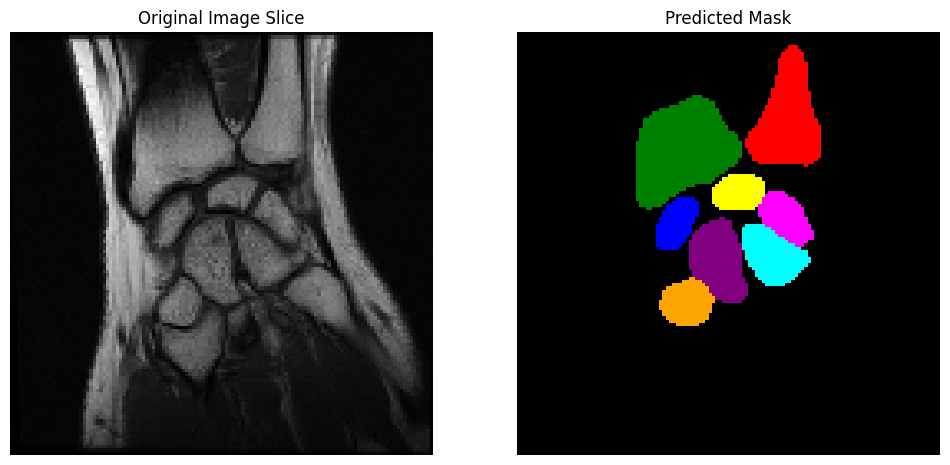

In [13]:
import os
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from matplotlib import colors

# Directory where predicted masks are saved
predicted_masks_dir = '/workspace/predicted_masks_dynunet'

# Function to visualize a saved predicted mask alongside the original image
def display_saved_mask(mask_path, original_image_slice, slice_num):
    # Load the predicted mask from the .nii.gz file
    predicted_mask_nii = nib.load(mask_path)
    predicted_mask_data = predicted_mask_nii.get_fdata()
    predicted_mask_slice = predicted_mask_data[:, :, slice_num]  # Extract the specific slice

    # Create a consistent colormap for visualization
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 6))

    # Display the original MRI image slice
    plt.subplot(1, 2, 1)
    plt.title("Original Image Slice")
    plt.imshow(original_image_slice, cmap='gray')
    plt.axis('off')

    # Display the predicted mask slice
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask_slice, cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Example to display a specific mask and corresponding original slice
# Loading the original MRI image (.nii.gz file)
mri_image_path = '/workspace/data/imagesTs/UN064_0000.nii.gz'  # Replace with the correct file path
mri_image = nib.load(mri_image_path)
mri_image_data = mri_image.get_fdata()

# Selecting the slice you want to visualize
slice_num = 22  # Change this to the specific slice number you want to check
original_image_slice = mri_image_data[:, :, slice_num]  # Extract the slice along the third dimension

# Constructing the path to the saved predicted mask
mask_filename = os.path.basename(mri_image_path)  # Get the filename of the original image
mask_path = os.path.join(predicted_masks_dir, mask_filename)  # Construct the corresponding mask path

# Displaying the saved predicted mask alongside the original image slice
display_saved_mask(mask_path, original_image_slice, slice_num)